# Terminator - Revamped

## Load Libs

In [24]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
%matplotlib inline

/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Important Functions

In [2]:
def runNameAnalysis(df):
    df['contains_bot'] = df['screen_name'].str.contains('bot',case=False)*1

def calculateRatios(df):
    df['ff_Ratio'] = (df['friends_count']+1)/(df['followers_count']+1)

def assumeVerification(df):
    df.ix[df['verified'].isnull() & df['ff_Ratio']<0.04,'verified'] = 1
    df.ix[df['verified'].isnull() & df['ff_Ratio']>0.04,'verified'] = 0

def isEnglish(df):
    df['english'] = 0
    df.ix[df['lang'].isin(['en','en-gb']),'english'] = 1
    
def assumeExtended(df):
    df.ix[df['has_extended_profile'].isnull() & df['ff_Ratio']<0.02,'has_extended_profile'] = 1
    df.ix[df['has_extended_profile'].isnull() & df['ff_Ratio']>0.02,'has_extended_profile'] = 0

## Training Data

In [3]:
# load data
traindata = pd.read_csv('training_data.csv', sep=",", encoding='latin1')
traindata.fillna('', inplace=True)

# add a column 'svm_guess' with a SVM classification of the description
traindata['svm_guess'] = pd.read_csv('svm_guess.csv', header=None)

runNameAnalysis(traindata)
isEnglish(traindata)

traindata = traindata.drop(['id', 'id_str', 'url', 'default_profile', 'default_profile_image', 'screen_name', 'location',
              'status', 'lang', 'description', 'created_at', 'name'], 1)

calculateRatios(traindata)
assumeVerification(traindata)
assumeExtended(traindata)
# print(np.mean(traindata[traindata['verified']==True]['ff_Ratio']))  #mean = 0.04

for c in traindata.columns:
    if(traindata[c].dtype==object):
        traindata[c] = (traindata[c]).astype(np.float64)

X_train = traindata.drop('bot',1)
y_train = traindata['bot']

## Test Data

In [4]:
testdata = pd.read_csv('test_data_4_students.csv', sep=",", encoding='utf-8')
testdata.fillna('', inplace=True)
testdata = testdata[:575]

# add a svm guess column
testdata['svm_guess'] = pd.read_csv('svm_test_guess.csv', header=None)

testdata['id'] = testdata['id'].astype(np.int64)
testdata = testdata.set_index(['id'])

In [5]:
# add a column 'name_analysis'
runNameAnalysis(testdata)

# do a language analysis thingy
isEnglish(testdata)

In [6]:
testdata = testdata.drop(['id_str', 'url', 'default_profile', 'default_profile_image', 'screen_name', 'location',
              'status', 'description', 'created_at', 'name','bot','lang'], 1)

In [7]:
for c in testdata.columns:
    if(testdata[c].dtype==object):
        testdata[c] = testdata[c].replace(['TRUE','FALSE','None'], [1,0,np.NaN])

for c in testdata.columns:
    if(testdata[c].dtype==object):
        testdata[c] = (testdata[c]).astype(np.float64)

for c in testdata.drop(['verified','has_extended_profile'],1).columns:
    testdata[c] = testdata[c].replace([np.NaN],testdata[c].mean(skipna=True, axis=0))

testdata.columns = ['followers_count', 'friends_count', 'listedcount', 'favourites_count',
       'verified', 'statuses_count','has_extended_profile','svm_guess','contains_bot','english']

In [8]:
testdata.head(5)

,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,has_extended_profile,svm_guess,contains_bot,english
id,,,,,,,,,,
2281292622,4466.0,1295.0,111.0,1579.000000,1.0,3036.0,0.0,0,0,1
2344040251,295.0,1016.0,10.0,300.000000,0.0,618.0,0.0,0,0,1
765871267,1001678.0,3017.0,14.0,13040.000000,1.0,3329.0,1.0,0,0,1
4772373433,445.0,487.0,17.0,1112.000000,0.0,46.0,1.0,1,0,0
1324548560,187.0,68.0,13.0,3576.781003,NaN,690359.0,NaN,1,1,0


In [9]:
# CALCULATE RATIOS HERE - AFTER TEST DATA HAS BEEN FIXED
calculateRatios(testdata)
assumeVerification(testdata)
assumeExtended(testdata)

In [10]:
testdata.head(5)

,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,has_extended_profile,svm_guess,contains_bot,english,ff_Ratio
id,,,,,,,,,,,
2281292622,4466.0,1295.0,111.0,1579.000000,1.0,3036.0,1.0,0,0,1,0.290128
2344040251,295.0,1016.0,10.0,300.000000,1.0,618.0,1.0,0,0,1,3.435811
765871267,1001678.0,3017.0,14.0,13040.000000,1.0,3329.0,1.0,0,0,1,0.003013
4772373433,445.0,487.0,17.0,1112.000000,1.0,46.0,1.0,1,0,0,1.094170
1324548560,187.0,68.0,13.0,3576.781003,0.0,690359.0,0.0,1,1,0,0.367021


## Remove Items

In [11]:
to_drop = ['svm_guess','listedcount','favourites_count']
X_train = X_train.drop(to_drop,1)
testdata = testdata.drop(to_drop,1)

## Model(s) - Weapon(s)

In [12]:
rfc = RandomForestClassifier()
param_grid = {'n_estimators': np.arange(10, 100, 10),
              'max_features': ['sqrt', 'log2', None],
              'criterion': ['gini', 'entropy'],
              }

'''
All Parameters in a RFC
            'max_depth':[None],
            'min_samples_split':[2],
            'min_samples_leaf':[1],
            'min_weight_fraction_leaf':[0.0],
            'max_leaf_nodes':[None],
            'min_impurity_split':[1e-07],
            'bootstrap':[True],
            'oob_score':[False],
            'n_jobs':[1],
            'random_state':[None],
            'verbose':[0],
            'warm_start':[False],
            'class_weight':[None]
'''
# # Performing a Grid Search to find best RFC
regular_RFC = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10)
regular_RFC.fit(X_train, y_train)
print('Grid Searched RF')
print(regular_RFC.best_params_)

print("RF: score of the best estimator over the leftout set:",regular_RFC.best_score_)
print("RF: score of the best estimator over the complete set:",regular_RFC.best_estimator_.score(X_train,y_train))
print()

Grid Searched RF
{'max_features': 'log2', 'n_estimators': 70, 'criterion': 'gini'}
RF: score of the best estimator over the leftout set: 0.890239542367
RF: score of the best estimator over the complete set: 0.998927422238



RSXG: score of the best estimator over the leftout set: 0.890239542367
RSXG: score of the best estimator over the complete set: 0.908115838398



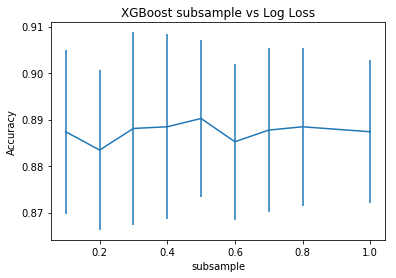

In [27]:
# XGBOOST
##############
# ROW SAMPLING
model = XGBClassifier()
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression()

subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(subsample=subsample)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
row_XG = grid_search.fit(X_train, y_train)

print("RSXG: score of the best estimator over the leftout set:",row_XG.best_score_)
print("RSXG: score of the best estimator over the complete set:",row_XG.best_estimator_.score(X_train,y_train))
print()

means_rs = row_XG.cv_results_['mean_test_score']
stds_rs = row_XG.cv_results_['std_test_score']

# plot
pyplot.figure()
pyplot.errorbar(subsample, means_rs, yerr=stds_rs)
pyplot.title("XGBoost subsample vs Accuracy")
pyplot.xlabel('subsample')
pyplot.ylabel('Accuracy')
pyplot.savefig('subsample.png')

CSXG: score of the best estimator over the leftout set: 0.891312120129
CSXG: score of the best estimator over the complete set: 0.907758312478



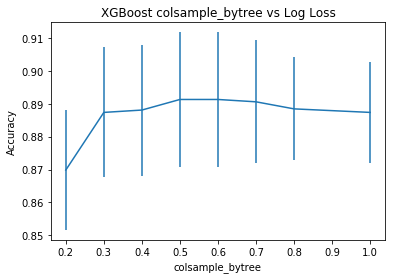

In [28]:
# COLUMN SAMPLING
colsample_bytree = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(colsample_bytree=colsample_bytree)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
col_XG = grid_search.fit(X_train, y_train)

print("CSXG: score of the best estimator over the leftout set:",col_XG.best_score_)
print("CSXG: score of the best estimator over the complete set:",col_XG.best_estimator_.score(X_train,y_train))
print()

means_cs = col_XG.cv_results_['mean_test_score']
stds_cs = col_XG.cv_results_['std_test_score']

# plot
pyplot.figure()
pyplot.errorbar(colsample_bytree, means_cs, yerr=stds_cs)
pyplot.title("XGBoost colsample_bytree vs Accuracy")
pyplot.xlabel('colsample_bytree')
pyplot.ylabel('Accuracy')
pyplot.savefig('colsample_bytree.png')

SSXG: score of the best estimator over the leftout set: 0.890239542367
SSXG: score of the best estimator over the complete set: 0.908115838398



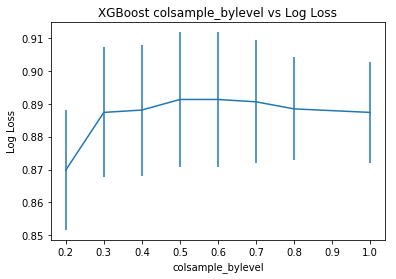

In [29]:
# SPLIT SAMPLE
colsample_bylevel = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(colsample_bylevel=colsample_bylevel)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
split_XG = grid_search.fit(X_train, y_train)

print("SSXG: score of the best estimator over the leftout set:",split_XG.best_score_)
print("SSXG: score of the best estimator over the complete set:",split_XG.best_estimator_.score(X_train,y_train))
print()

means_ss = col_XG.cv_results_['mean_test_score']
stds_ss = col_XG.cv_results_['std_test_score']

# plot
pyplot.figure()
pyplot.errorbar(colsample_bylevel, means_ss, yerr=stds_ss)
pyplot.title("XGBoost colsample_bylevel vs Accuracy")
pyplot.xlabel('colsample_bylevel')
pyplot.ylabel('Accuracy')
pyplot.savefig('colsample_bylevel.png')

### Nuke

In [21]:
# need a better model? 

In [17]:
np.max(testdata)

followers_count         9.691957e+07
friends_count           6.304920e+05
verified                1.000000e+00
statuses_count          1.618652e+06
has_extended_profile    1.000000e+00
contains_bot            1.000000e+00
english                 1.000000e+00
ff_Ratio                6.029201e+02
dtype: float64

## Create Predictions File

In [20]:
#select model from above
preds_for = split_XG

testdata['y_pred'] = preds_for.predict(testdata)
answer = pd.DataFrame(testdata['y_pred'])
answer.to_csv('results_file_new.csv',index=True,index_label='Id',header=['Bot'])
testdata = testdata.drop('y_pred',1)